# MoE Caching Speedup Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# KV Cache Offload Analysis

In [2]:
df = pd.read_csv("results/combined-data.csv")
df.head()

,model,config,size,prompt_set,policy,backend,trial_index,runtime_s,error,throughput_tok_s,...,avg_input_length,max_tokens,num_gpu_blocks,dest_gpu_id,gpu_mem_util.1,blocks_offloaded,blocks_reloaded,blocks_allocated,blocks_evicted,blocks_freed
0,facebook/opt-125m,opt-125m_xsmall_uniq_lru,xsmall,unique,lru,gpu,1,81.734208,NaN,75011.432507,...,131,6000,151668,1,0.032,70647,12,0,0,0
1,facebook/opt-125m,opt-125m_xsmall_uniq_lru,xsmall,unique,lru,cpu,1,87.755995,NaN,69864.172938,...,131,6000,151668,1,0.032,71947,12,0,0,0
2,facebook/opt-125m,opt-125m_xsmall_uniq_arc,xsmall,unique,arc,gpu,1,82.470808,NaN,74341.456254,...,131,6000,151668,1,0.032,68626,3,0,0,0
3,facebook/opt-125m,opt-125m_xsmall_uniq_arc,xsmall,unique,arc,cpu,1,80.802846,NaN,75876.039889,...,131,6000,151668,1,0.032,67207,3,0,0,0
4,facebook/opt-125m,opt-125m_small_uniq_lru,small,unique,lru,gpu,1,80.671457,NaN,75999.618892,...,131,6000,151668,1,0.032,67983,7,0,0,0


In [3]:
df.columns

Index(['model', 'config', 'size', 'prompt_set', 'policy', 'backend',
       'trial_index', 'runtime_s', 'error', 'throughput_tok_s',
       'compute_used_gb', 'compute_total_gb', 'dest_used_gb', 'dest_total_gb',
       'gpu_mem_util', 'offload_kv_capacity_gb', 'max_seq', 'avg_input_length',
       'max_tokens', 'num_gpu_blocks', 'dest_gpu_id', 'gpu_mem_util.1',
       'blocks_offloaded', 'blocks_reloaded', 'blocks_allocated',
       'blocks_evicted', 'blocks_freed'],
      dtype='object')

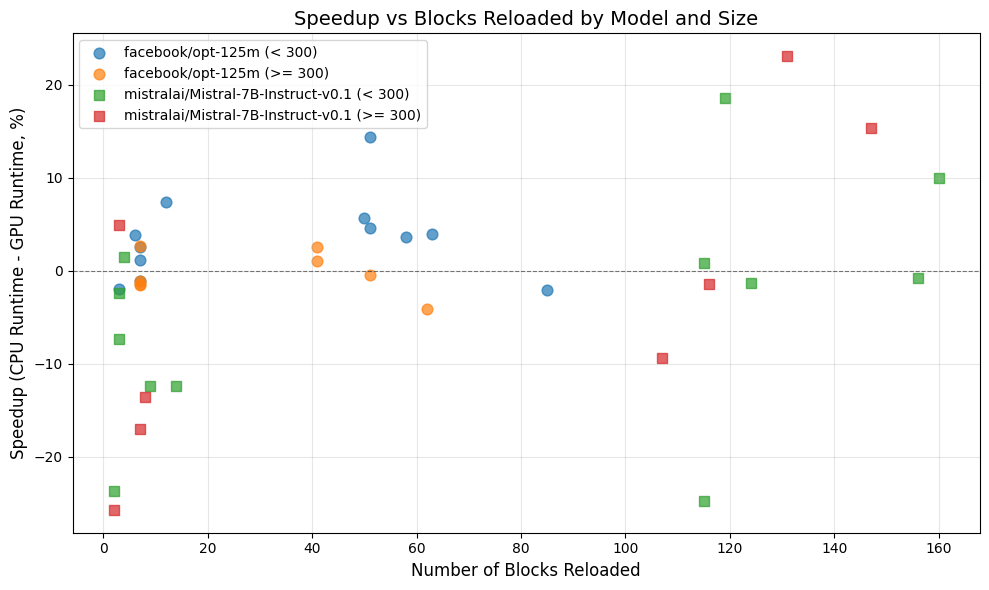

In [4]:
# Calculate speedup: CPU runtime - GPU runtime (in seconds and percentage)
# Group by config to match GPU and CPU runs
df_pivot = df.pivot_table(
    index=['model', 'config', 'trial_index', 'max_seq'],
    columns='backend',
    values=['runtime_s', 'blocks_reloaded'],
    aggfunc='first'
).reset_index()

# Flatten column names
df_pivot.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in df_pivot.columns.values]

# Calculate speedup (CPU runtime - GPU runtime in seconds)
df_pivot['speedup_seconds'] = df_pivot['runtime_s_cpu'] - df_pivot['runtime_s_gpu']
# Calculate speedup as percentage: (CPU runtime - GPU runtime) / GPU runtime * 100
df_pivot['speedup_percent'] = (df_pivot['runtime_s_cpu'] - df_pivot['runtime_s_gpu']) / df_pivot['runtime_s_gpu'] * 100
df_pivot['blocks_reloaded'] = df_pivot['blocks_reloaded_gpu'].fillna(df_pivot['blocks_reloaded_cpu'])

# Add size category based on max_seq
df_pivot['size_category'] = df_pivot['max_seq'].apply(lambda x: '>= 300' if x >= 300 else '< 300')

# Filter out rows with missing data
df_plot = df_pivot.dropna(subset=['speedup_seconds', 'blocks_reloaded'])

# Separate by model and size category
facebook_small = df_plot[(df_plot['model'] == 'facebook/opt-125m') & (df_plot['size_category'] == '< 300')]
facebook_large = df_plot[(df_plot['model'] == 'facebook/opt-125m') & (df_plot['size_category'] == '>= 300')]
mistral_small = df_plot[(df_plot['model'] == 'mistralai/Mistral-7B-Instruct-v0.1') & (df_plot['size_category'] == '< 300')]
mistral_large = df_plot[(df_plot['model'] == 'mistralai/Mistral-7B-Instruct-v0.1') & (df_plot['size_category'] == '>= 300')]

# Create the plot with color coding
plt.figure(figsize=(10, 6))
plt.scatter(facebook_small['blocks_reloaded'], facebook_small['speedup_percent'], 
           label='facebook/opt-125m (< 300)', alpha=0.7, s=60, c='#1f77b4', marker='o')
plt.scatter(facebook_large['blocks_reloaded'], facebook_large['speedup_percent'], 
           label='facebook/opt-125m (>= 300)', alpha=0.7, s=60, c='#ff7f0e', marker='o')
plt.scatter(mistral_small['blocks_reloaded'], mistral_small['speedup_percent'], 
           label='mistralai/Mistral-7B-Instruct-v0.1 (< 300)', alpha=0.7, s=60, c='#2ca02c', marker='s')
plt.scatter(mistral_large['blocks_reloaded'], mistral_large['speedup_percent'], 
           label='mistralai/Mistral-7B-Instruct-v0.1 (>= 300)', alpha=0.7, s=60, c='#d62728', marker='s')

plt.xlabel('Number of Blocks Reloaded', fontsize=12)
plt.ylabel('Speedup (CPU Runtime - GPU Runtime, %)', fontsize=12)
plt.title('Speedup vs Blocks Reloaded by Model and Size', fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()


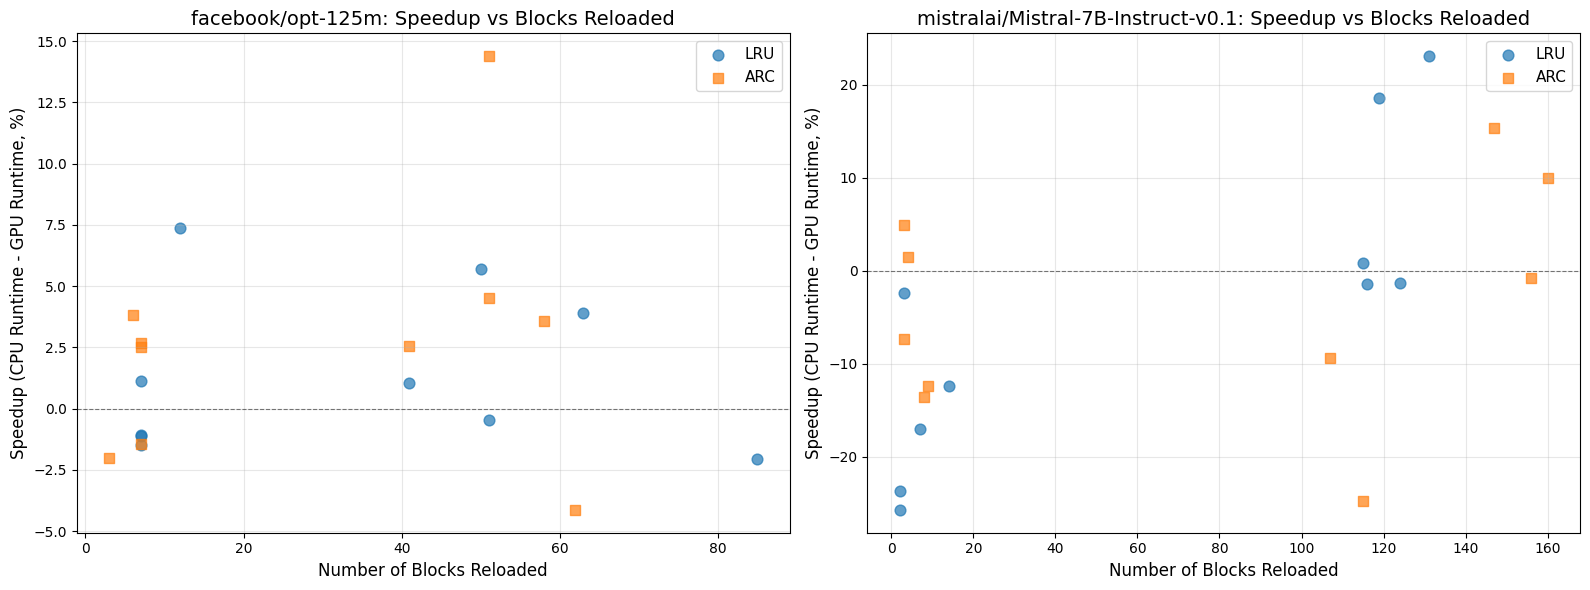

In [5]:
# Calculate speedup: CPU runtime - GPU runtime (in seconds and percentage)
# Group by config to match GPU and CPU runs - SEPARATE PLOTS BY POLICY
df_pivot_policy = df.pivot_table(
    index=['model', 'config', 'trial_index', 'policy'],
    columns='backend',
    values=['runtime_s', 'blocks_reloaded'],
    aggfunc='first'
).reset_index()

# Flatten column names
df_pivot_policy.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in df_pivot_policy.columns.values]

# Calculate speedup (CPU runtime - GPU runtime in seconds)
df_pivot_policy['speedup_seconds'] = df_pivot_policy['runtime_s_cpu'] - df_pivot_policy['runtime_s_gpu']
# Calculate speedup as percentage: (CPU runtime - GPU runtime) / GPU runtime * 100
df_pivot_policy['speedup_percent'] = (df_pivot_policy['runtime_s_cpu'] - df_pivot_policy['runtime_s_gpu']) / df_pivot_policy['runtime_s_gpu'] * 100
df_pivot_policy['blocks_reloaded'] = df_pivot_policy['blocks_reloaded_gpu'].fillna(df_pivot_policy['blocks_reloaded_cpu'])

# Filter out rows with missing data
df_plot_policy = df_pivot_policy.dropna(subset=['speedup_seconds', 'blocks_reloaded'])

# Separate by model and policy
facebook_df = df_plot_policy[df_plot_policy['model'] == 'facebook/opt-125m']
mistral_df = df_plot_policy[df_plot_policy['model'] == 'mistralai/Mistral-7B-Instruct-v0.1']

facebook_lru = facebook_df[facebook_df['policy'] == 'lru']
facebook_arc = facebook_df[facebook_df['policy'] == 'arc']
mistral_lru = mistral_df[mistral_df['policy'] == 'lru']
mistral_arc = mistral_df[mistral_df['policy'] == 'arc']

# Create two separate plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: facebook/opt-125m
ax1.scatter(facebook_lru['blocks_reloaded'], facebook_lru['speedup_percent'], 
           label='LRU', alpha=0.7, s=60, c='#1f77b4', marker='o')
ax1.scatter(facebook_arc['blocks_reloaded'], facebook_arc['speedup_percent'], 
           label='ARC', alpha=0.7, s=60, c='#ff7f0e', marker='s')
ax1.set_xlabel('Number of Blocks Reloaded', fontsize=12)
ax1.set_ylabel('Speedup (CPU Runtime - GPU Runtime, %)', fontsize=12)
ax1.set_title('facebook/opt-125m: Speedup vs Blocks Reloaded', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

# Plot 2: mistralai/Mistral-7B-Instruct-v0.1
ax2.scatter(mistral_lru['blocks_reloaded'], mistral_lru['speedup_percent'], 
           label='LRU', alpha=0.7, s=60, c='#1f77b4', marker='o')
ax2.scatter(mistral_arc['blocks_reloaded'], mistral_arc['speedup_percent'], 
           label='ARC', alpha=0.7, s=60, c='#ff7f0e', marker='s')
ax2.set_xlabel('Number of Blocks Reloaded', fontsize=12)
ax2.set_ylabel('Speedup (CPU Runtime - GPU Runtime, %)', fontsize=12)
ax2.set_title('mistralai/Mistral-7B-Instruct-v0.1: Speedup vs Blocks Reloaded', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

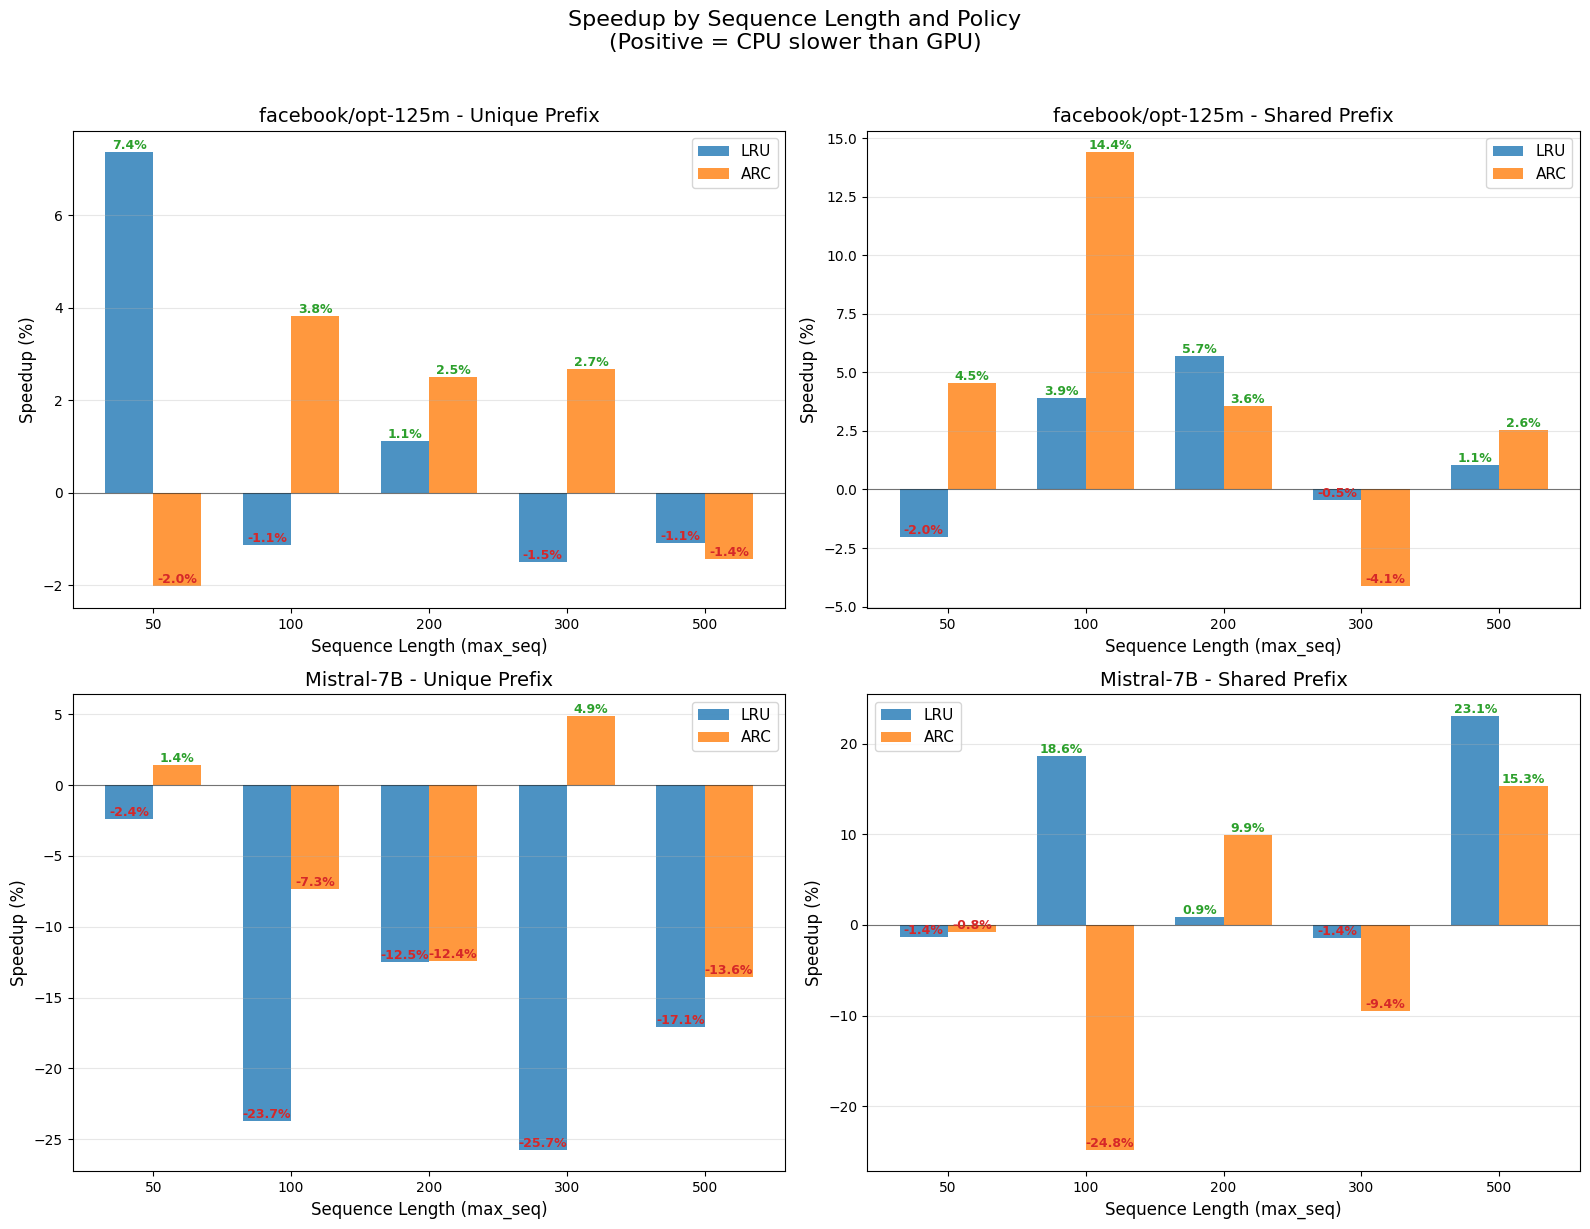

In [6]:
# Bar plot: Speedup percentages by sequence length (max_seq) and policy
# Now separated by prompt_set (unique vs shared_prefix)
import numpy as np

# Group by model, max_seq, policy, AND prompt_set to calculate speedup
df_pivot_bar = df.pivot_table(
    index=['model', 'config', 'trial_index', 'max_seq', 'policy', 'prompt_set'],
    columns='backend',
    values=['runtime_s'],
    aggfunc='first'
).reset_index()

# Flatten column names
df_pivot_bar.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in df_pivot_bar.columns.values]

# Calculate speedup percentage
df_pivot_bar['speedup_percent'] = (df_pivot_bar['runtime_s_cpu'] - df_pivot_bar['runtime_s_gpu']) / df_pivot_bar['runtime_s_gpu'] * 100

# Filter out rows with missing data
df_bar = df_pivot_bar.dropna(subset=['speedup_percent'])

# Calculate average speedup by model, max_seq, policy, and prompt_set
df_bar_avg = df_bar.groupby(['model', 'max_seq', 'policy', 'prompt_set'])['speedup_percent'].mean().reset_index()

# Get unique sequence lengths and sort them
seq_lengths = sorted(df_bar_avg['max_seq'].unique())
x_pos = np.arange(len(seq_lengths))
width = 0.35  # Width of bars

# Create 4 separate plots: 2x2 grid (model x prompt_set)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define the 4 combinations
combinations = [
    ('facebook/opt-125m', 'unique', 'facebook/opt-125m - Unique Prefix'),
    ('facebook/opt-125m', 'shared_prefix', 'facebook/opt-125m - Shared Prefix'),
    ('mistralai/Mistral-7B-Instruct-v0.1', 'unique', 'Mistral-7B - Unique Prefix'),
    ('mistralai/Mistral-7B-Instruct-v0.1', 'shared_prefix', 'Mistral-7B - Shared Prefix'),
]

for idx, (model, prompt_set, title) in enumerate(combinations):
    ax = axes[idx // 2, idx % 2]
    
    # Filter data for this model and prompt_set
    subset = df_bar_avg[(df_bar_avg['model'] == model) & (df_bar_avg['prompt_set'] == prompt_set)]
    
    lru_vals = []
    arc_vals = []
    for seq_len in seq_lengths:
        lru_data = subset[(subset['max_seq'] == seq_len) & (subset['policy'] == 'lru')]
        arc_data = subset[(subset['max_seq'] == seq_len) & (subset['policy'] == 'arc')]
        lru_vals.append(float(lru_data['speedup_percent'].iloc[0]) if len(lru_data) > 0 else 0.0)
        arc_vals.append(float(arc_data['speedup_percent'].iloc[0]) if len(arc_data) > 0 else 0.0)
    
    bars_lru = ax.bar(x_pos - width/2, lru_vals, width, label='LRU', color='#1f77b4', alpha=0.8)
    bars_arc = ax.bar(x_pos + width/2, arc_vals, width, label='ARC', color='#ff7f0e', alpha=0.8)
    
    # Add value labels on top of bars (green=speedup, red=slowdown)
    for bar, val in zip(bars_lru, lru_vals):
        if val != 0:
            color = '#2ca02c' if val > 0 else '#d62728'  # green if positive, red if negative
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)
    for bar, val in zip(bars_arc, arc_vals):
        if val != 0:
            color = '#2ca02c' if val > 0 else '#d62728'  # green if positive, red if negative
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)
    
    ax.set_xlabel('Sequence Length (max_seq)', fontsize=12)
    ax.set_ylabel('Speedup (%)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(seq_lengths)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

plt.suptitle('Speedup by Sequence Length and Policy\n(Positive = CPU slower than GPU)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Smaller models' data are "noisy"! KV Offload isn't domininating because there isn't enough latency incurred!!!

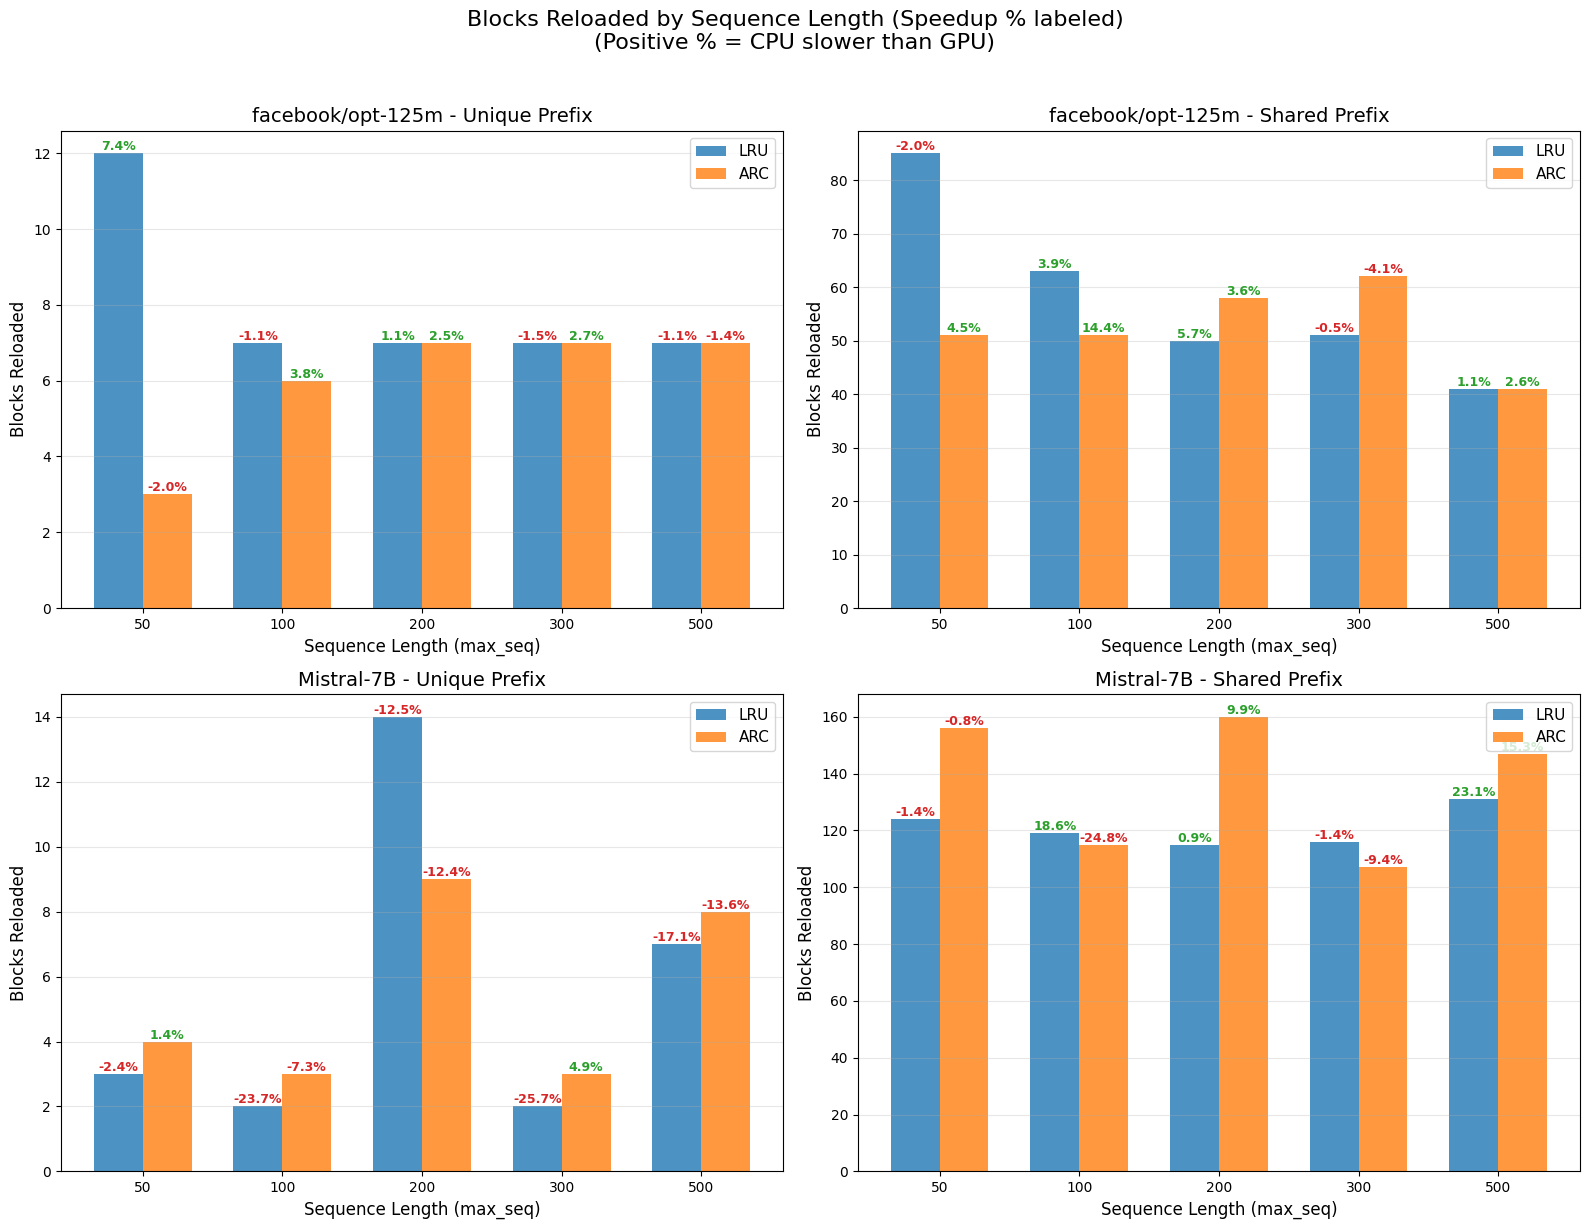

In [14]:
# Bar plot: Reload counts by sequence length with speedup percentages labeled
# Now separated by prompt_set (unique vs shared_prefix)
df_pivot_reload = df.pivot_table(
    index=['model', 'config', 'trial_index', 'max_seq', 'policy', 'prompt_set'],
    columns='backend',
    values=['runtime_s', 'blocks_reloaded'],
    aggfunc='first'
).reset_index()

# Flatten column names
df_pivot_reload.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in df_pivot_reload.columns.values]

# Calculate speedup percentage
df_pivot_reload['speedup_percent'] = (df_pivot_reload['runtime_s_cpu'] - df_pivot_reload['runtime_s_gpu']) / df_pivot_reload['runtime_s_gpu'] * 100
df_pivot_reload['blocks_reloaded'] = df_pivot_reload['blocks_reloaded_gpu'].fillna(df_pivot_reload['blocks_reloaded_cpu'])

# Filter out rows with missing data
df_reload = df_pivot_reload.dropna(subset=['speedup_percent', 'blocks_reloaded'])

# Calculate average blocks_reloaded and speedup by model, max_seq, policy, and prompt_set
df_reload_avg = df_reload.groupby(['model', 'max_seq', 'policy', 'prompt_set']).agg({
    'blocks_reloaded': 'mean',
    'speedup_percent': 'mean'
}).reset_index()

# Get unique sequence lengths and sort them
seq_lengths = sorted(df_reload_avg['max_seq'].unique())
x_pos = np.arange(len(seq_lengths))
width = 0.35  # Width of bars

# Create 4 separate plots: 2x2 grid (model x prompt_set)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define the 4 combinations
combinations = [
    ('facebook/opt-125m', 'unique', 'facebook/opt-125m - Unique Prefix'),
    ('facebook/opt-125m', 'shared_prefix', 'facebook/opt-125m - Shared Prefix'),
    ('mistralai/Mistral-7B-Instruct-v0.1', 'unique', 'Mistral-7B - Unique Prefix'),
    ('mistralai/Mistral-7B-Instruct-v0.1', 'shared_prefix', 'Mistral-7B - Shared Prefix'),
]

for idx, (model, prompt_set, title) in enumerate(combinations):
    ax = axes[idx // 2, idx % 2]
    
    # Filter data for this model and prompt_set
    subset = df_reload_avg[(df_reload_avg['model'] == model) & (df_reload_avg['prompt_set'] == prompt_set)]
    
    lru_reloads = []
    arc_reloads = []
    lru_speedups = []
    arc_speedups = []
    
    for seq_len in seq_lengths:
        lru_data = subset[(subset['max_seq'] == seq_len) & (subset['policy'] == 'lru')]
        arc_data = subset[(subset['max_seq'] == seq_len) & (subset['policy'] == 'arc')]
        lru_reloads.append(float(lru_data['blocks_reloaded'].iloc[0]) if len(lru_data) > 0 else 0.0)
        arc_reloads.append(float(arc_data['blocks_reloaded'].iloc[0]) if len(arc_data) > 0 else 0.0)
        lru_speedups.append(float(lru_data['speedup_percent'].iloc[0]) if len(lru_data) > 0 else 0.0)
        arc_speedups.append(float(arc_data['speedup_percent'].iloc[0]) if len(arc_data) > 0 else 0.0)
    
    bars_lru = ax.bar(x_pos - width/2, lru_reloads, width, label='LRU', color='#1f77b4', alpha=0.8)
    bars_arc = ax.bar(x_pos + width/2, arc_reloads, width, label='ARC', color='#ff7f0e', alpha=0.8)
    
    # Add speedup percentage labels on top of bars (green=speedup, red=slowdown)
    for bar, speedup in zip(bars_lru, lru_speedups):
        if speedup != 0:
            color = '#2ca02c' if speedup > 0 else '#d62728'  # green if positive, red if negative
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{speedup:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)
    for bar, speedup in zip(bars_arc, arc_speedups):
        if speedup != 0:
            color = '#2ca02c' if speedup > 0 else '#d62728'  # green if positive, red if negative
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{speedup:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)
    
    ax.set_xlabel('Sequence Length (max_seq)', fontsize=12)
    ax.set_ylabel('Blocks Reloaded', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(seq_lengths)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Blocks Reloaded by Sequence Length (Speedup % labeled)\n(Positive % = CPU slower than GPU)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Load the MoE caching data
moe_df = pd.read_csv('results/moe-caching.csv')

# Clean up the run_time_s column (some values have 's' suffix)
moe_df['run_time_s'] = moe_df['run_time_s'].astype(str).str.replace('s', '').astype(float)

# Group by model_name and gpu_offload, then calculate mean throughput
avg_throughput = moe_df.groupby(['model_name', 'gpu_offload'])['throughput_tok_s'].mean().unstack()

# Calculate percentage speedup: (caching_yes - caching_no) / caching_no * 100
speedup_pct = ((avg_throughput['yes'] - avg_throughput['no']) / avg_throughput['no']) * 100

# Create a summary dataframe
summary = pd.DataFrame({
    'avg_throughput_no_cache': avg_throughput['no'],
    'avg_throughput_with_cache': avg_throughput['yes'],
    'speedup_pct': speedup_pct
})

print("MoE Caching Speedup Analysis")
print("=" * 60)
print(summary.round(2))
print("\n")
print("Summary: Percentage speedup with caching enabled (gpu_offload=yes)")
print("-" * 60)
for model, pct in speedup_pct.items():
    print(f"{model}: {pct:.2f}% speedup")

MoE Caching Speedup Analysis
                                 avg_throughput_no_cache  \
model_name                                                 
Mixtral-8x7B                                      573.65   
Qwen2-MoE                                         378.19   
microsoft/Phi-3.5-MoE-instruct                    225.34   
microsoft/Phi-tiny-MoE-instruct                 12126.36   

                                 avg_throughput_with_cache  speedup_pct  
model_name                                                               
Mixtral-8x7B                                        897.56        56.46  
Qwen2-MoE                                           562.64        48.77  
microsoft/Phi-3.5-MoE-instruct                      475.83       111.16  
microsoft/Phi-tiny-MoE-instruct                   18809.95        55.12  


Summary: Percentage speedup with caching enabled (gpu_offload=yes)
------------------------------------------------------------
Mixtral-8x7B: 56.46% speedup
Qwen2-M

In [10]:
info = {
    "mixtral-8x7b": {
        "total_params_b": 47,
        "active_params_b": 13,
        "expert_count": 8,
        "active_expert_count": 2,
    },
    "Phi-3.5-MoE-instruct": {
        "total_params_b": 60.8,
        "active_params_b": 6.6,
        "expert_count": 16,
        "active_expert_count": 2,
    },
    "Phi-tiny-MoE-instruct": {
        "total_params_b": 3.8,
        "active_params_b": 1.1,
        "expert_count": 16,
        "active_expert_count": 2,
    },
    "Qwen2-MoE":{
        "total_params_b": 14.3,
        "active_params_b": 2.7,
        "expert_count": 64,
        "active_expert_count": 4,
    },
}

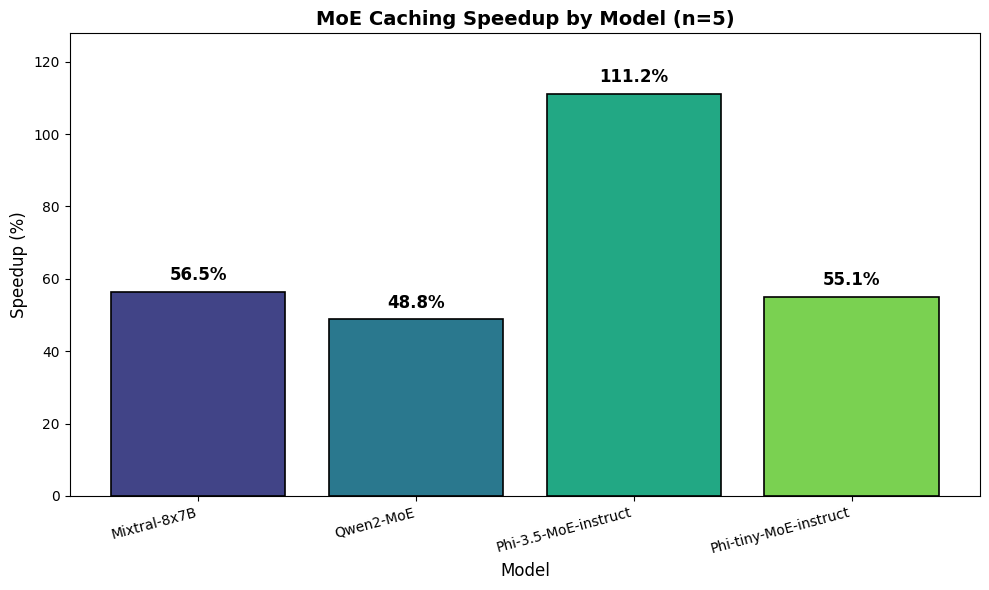

In [17]:
# Bar graph of average speedup per model
fig, ax = plt.subplots(figsize=(10, 6))

models = [m.split('/')[-1] for m in speedup_pct.index]  # Shorten model names
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models)))

bars = ax.bar(models, speedup_pct.values, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, val in zip(bars, speedup_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{val:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Speedup (%)', fontsize=12)
ax.set_title('MoE Caching Speedup by Model (n=5)', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(speedup_pct.values) * 1.15)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

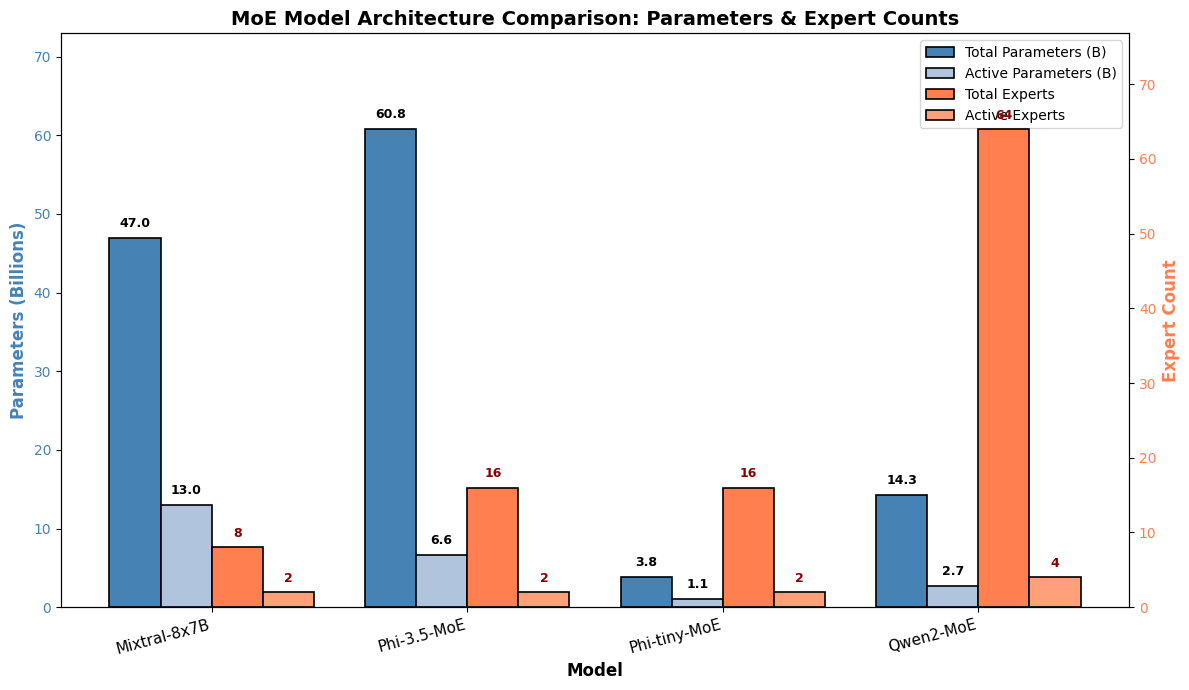

In [16]:
# Model Architecture Comparison: Parameters and Expert Counts
info = {
    "Mixtral-8x7B": {
        "total_params_b": 47,
        "active_params_b": 13,
        "expert_count": 8,
        "active_expert_count": 2,
    },
    "Phi-3.5-MoE": {
        "total_params_b": 60.8,
        "active_params_b": 6.6,
        "expert_count": 16,
        "active_expert_count": 2,
    },
    "Phi-tiny-MoE": {
        "total_params_b": 3.8,
        "active_params_b": 1.1,
        "expert_count": 16,
        "active_expert_count": 2,
    },
    "Qwen2-MoE": {
        "total_params_b": 14.3,
        "active_params_b": 2.7,
        "expert_count": 64,
        "active_expert_count": 4,
    },
}

# Extract data for plotting
models = list(info.keys())
total_params = [info[m]['total_params_b'] for m in models]
active_params = [info[m]['active_params_b'] for m in models]
expert_counts = [info[m]['expert_count'] for m in models]
active_experts = [info[m]['active_expert_count'] for m in models]

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 7))

x = np.arange(len(models))
width = 0.2

# Left y-axis: Parameters (in billions)
bars1 = ax1.bar(x - 1.5*width, total_params, width, label='Total Parameters (B)', 
                color='steelblue', edgecolor='black', linewidth=1.2)
bars2 = ax1.bar(x - 0.5*width, active_params, width, label='Active Parameters (B)', 
                color='lightsteelblue', edgecolor='black', linewidth=1.2)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Parameters (Billions)', fontsize=12, fontweight='bold', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right', fontsize=11)

# Right y-axis: Expert counts
ax2 = ax1.twinx()
bars3 = ax2.bar(x + 0.5*width, expert_counts, width, label='Total Experts', 
                color='coral', edgecolor='black', linewidth=1.2)
bars4 = ax2.bar(x + 1.5*width, active_experts, width, label='Active Experts', 
                color='lightsalmon', edgecolor='black', linewidth=1.2)

ax2.set_ylabel('Expert Count', fontsize=12, fontweight='bold', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

# Add value labels on bars
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars3:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')
for bar in bars4:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkred')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

ax1.set_title('MoE Model Architecture Comparison: Parameters & Expert Counts', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(total_params) * 1.2)
ax2.set_ylim(0, max(expert_counts) * 1.2)

plt.tight_layout()
plt.show()

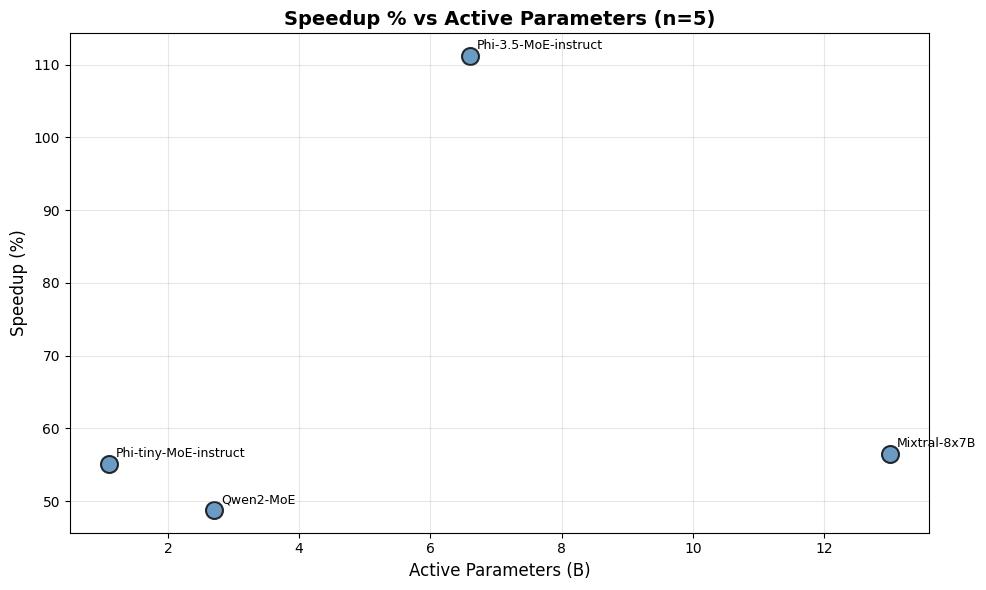

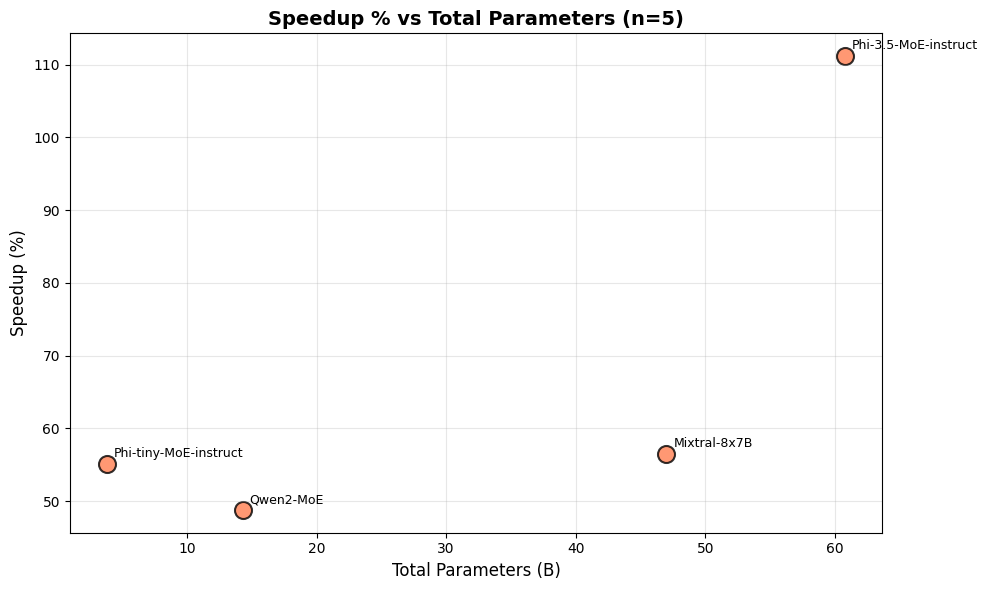

In [15]:
# Get parameter info per model (take first row for each model since params are constant)
param_info = moe_df.groupby('model_name')[['total_params_b', 'active_params_b']].first()

# Merge speedup with parameter info
speedup_df = pd.DataFrame({'speedup_pct': speedup_pct})
speedup_df = speedup_df.join(param_info)

# Plot 1: Speedup vs Active Parameters
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.scatter(speedup_df['active_params_b'], speedup_df['speedup_pct'], 
            s=150, c='steelblue', edgecolor='black', linewidth=1.5, alpha=0.8)

# Add model labels
for idx, row in speedup_df.iterrows():
    model_short = idx.split('/')[-1]
    ax1.annotate(model_short, (row['active_params_b'], row['speedup_pct']),
                 textcoords='offset points', xytext=(5, 5), fontsize=9)

ax1.set_xlabel('Active Parameters (B)', fontsize=12)
ax1.set_ylabel('Speedup (%)', fontsize=12)
ax1.set_title('Speedup % vs Active Parameters (n=5)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Speedup vs Total Parameters
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.scatter(speedup_df['total_params_b'], speedup_df['speedup_pct'], 
            s=150, c='coral', edgecolor='black', linewidth=1.5, alpha=0.8)

# Add model labels
for idx, row in speedup_df.iterrows():
    model_short = idx.split('/')[-1]
    ax2.annotate(model_short, (row['total_params_b'], row['speedup_pct']),
                 textcoords='offset points', xytext=(5, 5), fontsize=9)

ax2.set_xlabel('Total Parameters (B)', fontsize=12)
ax2.set_ylabel('Speedup (%)', fontsize=12)
ax2.set_title('Speedup % vs Total Parameters (n=5)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# 1. Load your full results CSV
# Replace "runs.csv" with your actual filename
df = pd.read_csv("results/combined-data.csv")

# 2. Keep only the columns we care about for joining / calculations
# (we'll use these as keys to match CPU vs GPU runs)
join_cols = [
    "model",
    "config",
    "size",
    "prompt_set",
    "policy",
    "max_seq",
    "avg_input_length",
    "max_tokens",
    "num_gpu_blocks",
    "dest_gpu_id",
    "offload_kv_capacity_gb"
]

# 3. Split GPU and CPU rows
gpu_df = df[df["backend"] == "gpu"].copy()
cpu_df = df[df["backend"] == "cpu"].copy()

# Rename runtime and blocks columns so we can distinguish after merge
gpu_df = gpu_df.rename(
    columns={
        "runtime_s": "runtime_gpu_s",
        "blocks_offloaded": "blocks_offloaded_gpu"
    }
)
cpu_df = cpu_df.rename(
    columns={
        "runtime_s": "runtime_cpu_s",
        "blocks_offloaded": "blocks_offloaded_cpu"
    }
)

# 4. Merge GPU + CPU runs on the join keys
merged = pd.merge(
    gpu_df[join_cols + ["runtime_gpu_s", "blocks_offloaded_gpu"]],
    cpu_df[join_cols + ["runtime_cpu_s", "blocks_offloaded_cpu"]],
    on=join_cols,
    how="inner",
    validate="one_to_one",
)

# 5. Compute % speedup: positive means GPU+offload is faster than CPU
merged["speedup_pct"] = (
    (merged["runtime_cpu_s"] - merged["runtime_gpu_s"])
    / merged["runtime_cpu_s"]
) * 100.0

# 6. Simplify model name to "opt" or "mistral"
def simplify_model_name(full_name: str) -> str:
    name_lower = full_name.lower()
    if "opt" in name_lower:
        return "opt"
    if "mistral" in name_lower:
        return "mistral"
    return full_name  # fallback if you add more models later

merged["model_simple"] = merged["model"].apply(simplify_model_name)

# 7. Build final summary table
summary = merged[[
    "model_simple",
    "max_seq",
    "speedup_pct",
    "policy",
    "avg_input_length",
    "blocks_offloaded_gpu",
]].rename(
    columns={
        "model_simple": "model",
        "blocks_offloaded_gpu": "blocks_offloaded",
    }
)

# 8. Sort for readability (model → policy → max_seq)
summary = summary.sort_values(["model", "policy", "max_seq"]).reset_index(drop=True)

print(summary)

# Optionally: get separate tables per policy if you want
summary_lru = summary[summary["policy"] == "lru"]
summary_arc = summary[summary["policy"] == "arc"]

print("\nLRU rows:\n", summary_lru)
print("\nARC rows:\n", summary_arc)

      model  max_seq  speedup_pct policy  avg_input_length  blocks_offloaded
0   mistral       50     1.426690    arc               105             49961
1   mistral       50    -0.764846    arc                80             29422
2   mistral      100    -7.913513    arc               105             52727
3   mistral      100   -32.954062    arc                80             28622
4   mistral      200   -14.145621    arc               105             57412
5   mistral      200     9.016182    arc                80             30656
6   mistral      300     4.674314    arc               105             50461
7   mistral      300   -10.417274    arc                80             30643
8   mistral      500   -15.682209    arc               105             53503
9   mistral      500    13.305173    arc                80             28764
10  mistral       50    -2.476013    lru               105             52442
11  mistral       50    -1.376271    lru                80             29325

In [22]:
import pandas as pd

# starting from your existing `summary` df

# 1. Pivot so that LRU and ARC become side-by-side columns
wide = summary.pivot(
    index=["model", "max_seq", "avg_input_length"],
    columns="policy",
    values=["speedup_pct", "blocks_offloaded"],
)

# 2. Flatten the MultiIndex columns: ('speedup_pct', 'arc') → 'speedup_pct_arc', etc.
wide.columns = [f"{metric}_{pol}" for metric, pol in wide.columns]

wide = wide.reset_index()

# 3. Compute difference between ARC and LRU speedups (in percentage points)
wide["speedup_diff_pctpoints"] = wide["speedup_pct_arc"] - wide["speedup_pct_lru"]

#4. (Optional) compute relative % difference vs LRU if you want it too:
wide["speedup_diff_vs_lru_percent"] = (
    (wide["speedup_pct_arc"] - wide["speedup_pct_lru"]) / wide["speedup_pct_lru"].abs()
) * 100.0

# 5. For readability, reorder columns
wide = wide[
    [
        "model",
        "max_seq",
        "avg_input_length",
        "speedup_pct_lru",
        "speedup_pct_arc",
        "speedup_diff_pctpoints",
        "blocks_offloaded_lru",
        "blocks_offloaded_arc",
    ]
].sort_values(["model", "max_seq", "avg_input_length"])

# --- FORMAT OUTPUT NICELY ---

# Round numeric columns to 2 decimals
for col in [
    "speedup_pct_lru",
    "speedup_pct_arc",
    "speedup_diff_pctpoints",
]:
    wide[col] = wide[col].round(2)

# Convert speedup columns into "xx.xx%" strings
for col in ["speedup_pct_lru", "speedup_pct_arc", "speedup_diff_pctpoints"]:
    wide[col] = wide[col].astype(str) + "%"

# Round block counts (they are floats after pivot)
wide["blocks_offloaded_lru"] = wide["blocks_offloaded_lru"].round(0).astype(int)
wide["blocks_offloaded_arc"] = wide["blocks_offloaded_arc"].round(0).astype(int)

# Make sure printing shows full width on one line
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

print(wide)

      model  max_seq  avg_input_length speedup_pct_lru speedup_pct_arc speedup_diff_pctpoints  blocks_offloaded_lru  blocks_offloaded_arc
0   mistral       50                80          -1.38%          -0.76%                  0.61%                 29325                 29422
1   mistral       50               105          -2.48%           1.43%                   3.9%                 52442                 49961
2   mistral      100                80          15.68%         -32.95%                -48.64%                 27518                 28622
3   mistral      100               105         -31.13%          -7.91%                 23.21%                 58260                 52727
4   mistral      200                80           0.85%           9.02%                  8.17%                 28622                 30656
5   mistral      200               105         -14.22%         -14.15%                  0.08%                 54609                 57412
6   mistral      300              

In [23]:
wide.to_csv("kv_cache_results_table.csv", index=False)

In [26]:
import pandas as pd

# 1. Load your full results CSV
df = pd.read_csv("results/combined-data.csv")

# 2. Keep only the columns we care about for joining / calculations
join_cols = [
    "model",
    "config",
    "size",
    "prompt_set",           # <-- we'll use this to tag shared/unique in the name
    "policy",
    "max_seq",
    "avg_input_length",
    "max_tokens",
    "num_gpu_blocks",
    "dest_gpu_id",
    "offload_kv_capacity_gb"
]

# 3. Split GPU and CPU rows
gpu_df = df[df["backend"] == "gpu"].copy()
cpu_df = df[df["backend"] == "cpu"].copy()

# Rename runtime and blocks columns so we can distinguish after merge
gpu_df = gpu_df.rename(
    columns={
        "runtime_s": "runtime_gpu_s",
        "blocks_offloaded": "blocks_offloaded_gpu"
    }
)
cpu_df = cpu_df.rename(
    columns={
        "runtime_s": "runtime_cpu_s",
        "blocks_offloaded": "blocks_offloaded_cpu"
    }
)

# 4. Merge GPU + CPU runs on the join keys
merged = pd.merge(
    gpu_df[join_cols + ["runtime_gpu_s", "blocks_offloaded_gpu"]],
    cpu_df[join_cols + ["runtime_cpu_s", "blocks_offloaded_cpu"]],
    on=join_cols,
    how="inner",
    validate="one_to_one",
)

# 5. Compute % speedup: positive means GPU+offload is faster than CPU
merged["speedup_pct"] = (
    (merged["runtime_cpu_s"] - merged["runtime_gpu_s"])
    / merged["runtime_cpu_s"]
) * 100.0

# 6. Simplify model name to "opt" or "mistral"
def simplify_model_name(full_name: str) -> str:
    name_lower = full_name.lower()
    if "opt" in name_lower:
        return "opt"
    if "mistral" in name_lower:
        return "mistral"
    return full_name  # fallback if you add more models later

merged["model_simple"] = merged["model"].apply(simplify_model_name)

# 6b. Combine model + prompt_set → e.g. "mistral-shared", "mistral-unique"
# (Assumes prompt_set values are like "shared"/"unique")
merged["model_with_prompts"] = merged["model_simple"] + "-" + merged["prompt_set"]

# 7. Build final summary table
summary = merged[[
    "model_with_prompts",
    "max_seq",
    "speedup_pct",
    "policy",
    "avg_input_length",
    "blocks_offloaded_gpu",
]].rename(
    columns={
        "model_with_prompts": "model",
        "blocks_offloaded_gpu": "blocks_offloaded",
    }
)

# 8. Sort for readability (model → policy → max_seq)
summary = summary.sort_values(["model", "policy", "max_seq"]).reset_index(drop=True)

print(summary)

# Optionally: get separate tables per policy if you want
summary_lru = summary[summary["policy"] == "lru"]
summary_arc = summary[summary["policy"] == "arc"]

print("\nLRU rows:\n", summary_lru)
print("\nARC rows:\n", summary_arc)



                    model  max_seq  speedup_pct policy  avg_input_length  blocks_offloaded
0   mistral-shared_prefix       50    -0.764846    arc                80             29422
1   mistral-shared_prefix      100   -32.954062    arc                80             28622
2   mistral-shared_prefix      200     9.016182    arc                80             30656
3   mistral-shared_prefix      300   -10.417274    arc                80             30643
4   mistral-shared_prefix      500    13.305173    arc                80             28764
5   mistral-shared_prefix       50    -1.376271    lru                80             29325
6   mistral-shared_prefix      100    15.684208    lru                80             27518
7   mistral-shared_prefix      200     0.851105    lru                80             28622
8   mistral-shared_prefix      300    -1.406832    lru                80             29369
9   mistral-shared_prefix      500    18.747893    lru                80             28125

In [27]:
summary.to_csv("kv_cache_results_table.csv", index=False)

# Alibaba PAI Cluster GPU Memory Analysis

Analyzing available GPU memory from Alibaba's PAI cluster traces to understand GPU memory utilization patterns in production ML workloads.m: https://github.com/alibaba/clusterdata/tree/master/cluster-trace-gpu-v2020

In [7]:
# Load the PAI cluster data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = "/home/azureuser/clusterdata/cluster-trace-gpu-v2020/data"

def load_pai_table(table_name):
    """Load a PAI table using its header file for column names."""
    header_path = f"{DATA_DIR}/{table_name}.header"
    csv_path = f"{DATA_DIR}/{table_name}.csv"
    
    # Read header file to get column names
    with open(header_path, 'r') as f:
        header_line = f.readline().strip()
    columns = header_line.split(',')
    
    # Load CSV with the header columns (CSV has no header row)
    df = pd.read_csv(csv_path, names=columns, header=None)
    return df

# Load the tables we need
print("Loading sensor table...")
sensor_df = load_pai_table("pai_sensor_table")
print(f"  Loaded {len(sensor_df):,} rows, columns: {list(sensor_df.columns)}")

print("Loading task table...")
task_df = load_pai_table("pai_task_table")
print(f"  Loaded {len(task_df):,} rows, columns: {list(task_df.columns)}")

print("Loading machine spec table...")
machine_spec_df = load_pai_table("pai_machine_spec")
print(f"  Loaded {len(machine_spec_df):,} rows, columns: {list(machine_spec_df.columns)}")

print("Loading instance table...")
instance_df = load_pai_table("pai_instance_table")
print(f"  Loaded {len(instance_df):,} rows, columns: {list(instance_df.columns)}")


Loading sensor table...
  Loaded 3,033,232 rows, columns: ['job_name', 'task_name', 'worker_name', 'inst_id', 'machine', 'gpu_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count', 'write_count']
Loading task table...
  Loaded 1,261,050 rows, columns: ['job_name', 'task_name', 'inst_num', 'status', 'start_time', 'end_time', 'plan_cpu', 'plan_mem', 'plan_gpu', 'gpu_type']
Loading machine spec table...
  Loaded 1,897 rows, columns: ['machine', 'gpu_type', 'cap_cpu', 'cap_mem', 'cap_gpu']
Loading instance table...
  Loaded 7,522,002 rows, columns: ['job_name', 'task_name', 'inst_name', 'worker_name', 'inst_id', 'status', 'start_time', 'end_time', 'machine']


In [8]:
# Explore the data structure
print("=== Sensor Table Columns ===")
print(sensor_df.columns.tolist())
print(f"\nSample rows:")
sensor_df.head()

=== Sensor Table Columns ===
['job_name', 'task_name', 'worker_name', 'inst_id', 'machine', 'gpu_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'read_count', 'write_count']

Sample rows:


,job_name,task_name,worker_name,inst_id,machine,gpu_name,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,read,write,read_count,write_count
0,c6acdbd813439f3ca63a9406,worker,d50591d4a39b5a68e7efa15a0b51cfdca03e8f7a49ade7...,dc6e6daefec62bc3729def7e15133c03b82a97a1457d68...,4a57d4f3d41316da3c4ae876,/dev/nvidia5,0.603296,0.000000,0.232509,0.256836,0.000000,0.000000,4.666371e+03,6.608757e+03,50.706367,47.831054
1,c6acdbd813439f3ca63a9406,worker,fd1ee8bacf027604c2afdf89fc4edd843322b78376c9df...,dc6e6daefec62bc3729def7e15133c03b82a97a1457d68...,d84f5bc585e4ac5d24b30ec1,/dev/nvidia7,1.039332,0.000000,0.305684,0.343750,0.000000,0.000000,9.073576e+03,6.643213e+03,80.299497,47.311857
2,c6acdbd813439f3ca63a9406,worker,8885c53fd558926cb6aa44bbb7f40e242093778988c57d...,dc6e6daefec62bc3729def7e15133c03b82a97a1457d68...,b8dca09e0247ec64355414f9,/dev/nvidia2,0.287556,0.000000,0.345654,0.436523,0.000000,0.000000,4.852393e+03,6.681694e+03,50.627430,47.857114
3,3e4e9725920e7dc4a7a4ebdd,worker,8170c081a8d69cc228b9c2fa13a1c5e1190bf215296816...,ccc2b2c5742997e7ed0459efa6ec3db8b8e56e3f7fcd5f...,f7c1c4979c05bb7d20da65e4,/dev/nvidia7,83.771930,18.883333,5.817499,6.886719,2.065153,2.317383,1.504240e+08,5.082606e+07,7119.393443,75116.196721
4,3e4e9725920e7dc4a7a4ebdd,worker,e43f95191455f15365b40289c32b44648ce1e501331119...,ccc2b2c5742997e7ed0459efa6ec3db8b8e56e3f7fcd5f...,142a829a1e344f905fdcce42,/dev/nvidia2,112.711111,27.000000,5.494639,6.951172,2.001526,2.317383,1.854764e+08,6.311824e+07,9050.204082,93378.387755


In [10]:
# Check GPU types in machine spec and task tables
print("=== GPU Types in Machine Spec ===")
print(machine_spec_df['gpu_type'].value_counts())

print("\n=== GPU Types in Task Table ===")
print(task_df['gpu_type'].value_counts())


=== GPU Types in Machine Spec ===
gpu_type
P100       798
T4         497
MISC       280
V100M32    135
V100       104
CPU         83
Name: count, dtype: int64

=== GPU Types in Task Table ===
gpu_type
MISC       696281
T4         226923
P100        72732
V100        28797
V100M32     18579
Name: count, dtype: int64


In [20]:
# Analyze GPU memory usage to determine GPU variants
# If max_gpu_wrk_mem > 12GB for a GPU type, it's definitely a 16GB+ variant

print("=== GPU Memory Usage Analysis by GPU Type ===\n")

for gpu_type in sensor_with_gpu['gpu_type'].dropna().unique():
    subset = sensor_with_gpu[sensor_with_gpu['gpu_type'] == gpu_type]
    max_usage = subset['max_gpu_wrk_mem'].max()
    avg_of_max = subset['max_gpu_wrk_mem'].mean()
    p99_usage = subset['max_gpu_wrk_mem'].quantile(0.99)
    p999_usage = subset['max_gpu_wrk_mem'].quantile(0.999)
    count_above_12 = (subset['max_gpu_wrk_mem'] > 12).sum()
    count_above_16 = (subset['max_gpu_wrk_mem'] > 16).sum()
    count_above_24 = (subset['max_gpu_wrk_mem'] > 24).sum()
    total = len(subset)
    
    print(f"GPU Type: {gpu_type}")
    print(f"  Total instances: {total:,}")
    print(f"  Max GPU memory used: {max_usage:.2f} GB")
    print(f"  Mean of max GPU memory: {avg_of_max:.2f} GB")
    print(f"  P99 GPU memory: {p99_usage:.2f} GB")
    print(f"  P99.9 GPU memory: {p999_usage:.2f} GB")
    print(f"  Instances using >12 GB: {count_above_12:,} ({count_above_12/total*100:.2f}%)")
    print(f"  Instances using >16 GB: {count_above_16:,} ({count_above_16/total*100:.2f}%)")
    print(f"  Instances using >24 GB: {count_above_24:,} ({count_above_24/total*100:.2f}%)")
    print()


=== GPU Memory Usage Analysis by GPU Type ===

GPU Type: V100M32
  Total instances: 43,553
  Max GPU memory used: 253.65 GB
  Mean of max GPU memory: 25.28 GB
  P99 GPU memory: 235.44 GB
  P99.9 GPU memory: 253.34 GB
  Instances using >12 GB: 12,130 (27.85%)
  Instances using >16 GB: 10,786 (24.77%)
  Instances using >24 GB: 8,445 (19.39%)

GPU Type: MISC
  Total instances: 1,893,444
  Max GPU memory used: 83.35 GB
  Mean of max GPU memory: 1.74 GB
  P99 GPU memory: 10.54 GB
  P99.9 GPU memory: 10.91 GB
  Instances using >12 GB: 1,345 (0.07%)
  Instances using >16 GB: 901 (0.05%)
  Instances using >24 GB: 170 (0.01%)

GPU Type: P100
  Total instances: 467,327
  Max GPU memory used: 87.26 GB
  Mean of max GPU memory: 3.20 GB
  P99 GPU memory: 15.60 GB
  P99.9 GPU memory: 30.61 GB
  Instances using >12 GB: 18,747 (4.01%)
  Instances using >16 GB: 1,822 (0.39%)
  Instances using >24 GB: 981 (0.21%)

GPU Type: V100
  Total instances: 64,843
  Max GPU memory used: 125.80 GB
  Mean of max GP

In [ ]:
# Histogram of max GPU memory usage for P100 specifically
# Look for evidence of 12GB vs 16GB variants

p100_mem = sensor_with_gpu[sensor_with_gpu['gpu_type'] == 'P100']['max_gpu_wrk_mem'].dropna()

if len(p100_mem) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.hist(p100_mem, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(x=12, color='red', linestyle='--', linewidth=2, label='12 GB threshold')
    ax.axvline(x=16, color='orange', linestyle='--', linewidth=2, label='16 GB threshold')
    
    ax.set_xlabel('Max GPU Memory Used (GB)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'P100: Max GPU Memory Usage Distribution (n={len(p100_mem):,})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nP100 instances using >12 GB: {(p100_mem > 12).sum():,} out of {len(p100_mem):,}")
    print(f"P100 max memory observed: {p100_mem.max():.2f} GB")
else:
    print("No P100 data found in sensor_with_gpu")


In [12]:
# Define GPU memory capacity mapping (in GB)
# Based on known GPU specifications
GPU_MEMORY_GB = {
    'V100M32': 32.0,   # NVIDIA V100 32GB variant
    'V100': 16.0,      # NVIDIA V100 16GB variant (if exists)
    'T4': 16.0,        # NVIDIA T4
    'P100': 16.0,      # NVIDIA P100
    'MISC': -10000000,      # Older GPUs (K40m, K80, M60) - conservative estimate
}

# Join sensor data with instance data to get machine info
# Then join with machine_spec to get GPU type
print("Joining sensor data with instance and machine spec tables...")

# First, join sensor with instance on worker_name to get machine
sensor_with_machine = sensor_df.merge(
    instance_df[['worker_name', 'machine', 'job_name', 'task_name']].drop_duplicates(),
    on=['worker_name', 'job_name', 'task_name'],
    how='left',
    suffixes=('', '_inst')
)

# Use the machine from sensor if available, otherwise from instance
sensor_with_machine['machine_final'] = sensor_with_machine['machine'].fillna(sensor_with_machine.get('machine_inst', ''))

print(f"Rows with machine info: {sensor_with_machine['machine_final'].notna().sum():,} / {len(sensor_with_machine):,}")


Joining sensor data with instance and machine spec tables...
Rows with machine info: 3,033,232 / 3,033,232


In [13]:
# Join with machine_spec to get GPU type
# The sensor table already has 'machine' column, let's use it directly
sensor_with_gpu = sensor_df.merge(
    machine_spec_df[['machine', 'gpu_type']],
    on='machine',
    how='left'
)

print(f"Rows with GPU type: {sensor_with_gpu['gpu_type'].notna().sum():,} / {len(sensor_with_gpu):,}")
print(f"\nGPU type distribution in sensor data:")
print(sensor_with_gpu['gpu_type'].value_counts(dropna=False))


Rows with GPU type: 3,033,223 / 3,033,232

GPU type distribution in sensor data:
gpu_type
MISC       1893444
T4          564056
P100        467327
V100         64843
V100M32      43553
NaN              9
Name: count, dtype: int64


In [14]:
# Calculate available GPU memory per instance
# Available = GPU Capacity - max_gpu_wrk_mem (max GPU memory used)

# Map GPU type to memory capacity
sensor_with_gpu['gpu_capacity_gb'] = sensor_with_gpu['gpu_type'].map(GPU_MEMORY_GB)

# Filter to rows that have both GPU type and GPU memory usage data
gpu_data = sensor_with_gpu[
    (sensor_with_gpu['gpu_capacity_gb'].notna()) & 
    (sensor_with_gpu['max_gpu_wrk_mem'].notna()) &
    (sensor_with_gpu['max_gpu_wrk_mem'] > 0)  # Only instances that used GPU memory
].copy()

print(f"Instances with valid GPU memory data: {len(gpu_data):,}")

# Calculate available GPU memory
gpu_data['available_gpu_mem_gb'] = gpu_data['gpu_capacity_gb'] - gpu_data['max_gpu_wrk_mem']

# Handle edge cases where usage exceeds capacity (data quality issues)
gpu_data['available_gpu_mem_gb'] = gpu_data['available_gpu_mem_gb'].clip(lower=0)

# Summary statistics
print(f"\n=== GPU Memory Usage Statistics ===")
print(f"Mean GPU memory used: {gpu_data['max_gpu_wrk_mem'].mean():.2f} GB")
print(f"Median GPU memory used: {gpu_data['max_gpu_wrk_mem'].median():.2f} GB")
print(f"Mean available GPU memory: {gpu_data['available_gpu_mem_gb'].mean():.2f} GB")
print(f"Median available GPU memory: {gpu_data['available_gpu_mem_gb'].median():.2f} GB")


Instances with valid GPU memory data: 2,537,812

=== GPU Memory Usage Statistics ===
Mean GPU memory used: 2.80 GB
Median GPU memory used: 0.90 GB
Mean available GPU memory: 5.07 GB
Median available GPU memory: 0.00 GB


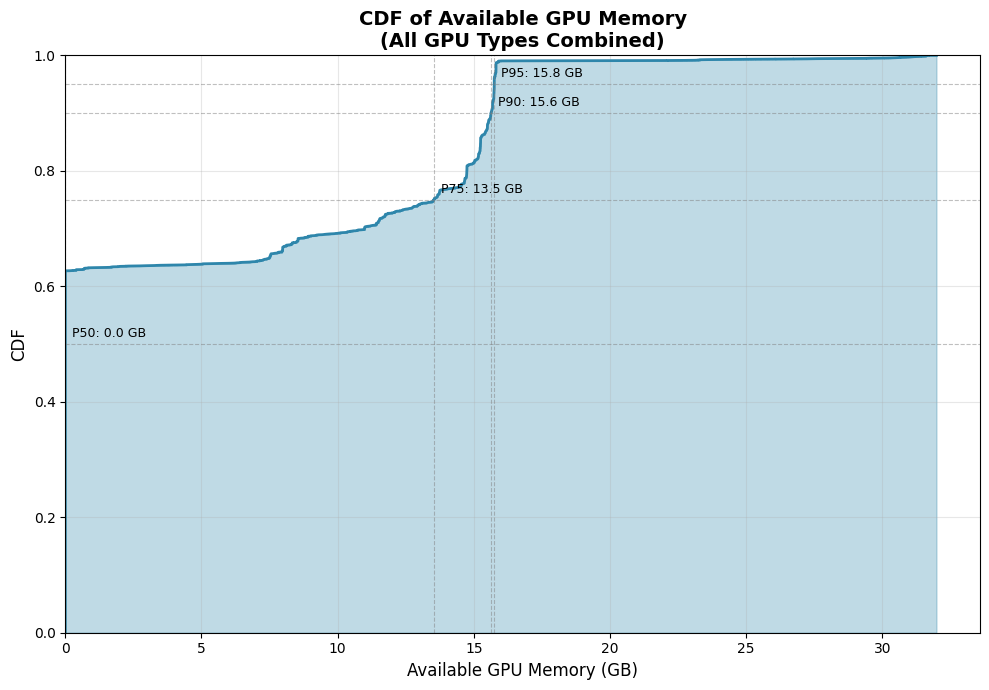

Figure saved as 'gpu_memory_cdf_combined.png'


In [22]:
# Plot 1: CDF of available GPU memory (all GPU types combined)
fig1, ax1 = plt.subplots(figsize=(10, 7))

sorted_available = np.sort(gpu_data['available_gpu_mem_gb'])
cdf = np.arange(1, len(sorted_available) + 1) / len(sorted_available)

ax1.plot(sorted_available, cdf, linewidth=2, color='#2E86AB')
ax1.fill_between(sorted_available, cdf, alpha=0.3, color='#2E86AB')
ax1.set_xlabel('Available GPU Memory (GB)', fontsize=12)
ax1.set_ylabel('CDF', fontsize=12)
ax1.set_title('CDF of Available GPU Memory\n(All GPU Types Combined)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max(sorted_available) * 1.05)
ax1.set_ylim(0, 1)

# Add percentile markers
percentiles = [50, 75, 90, 95]
for p in percentiles:
    val = np.percentile(sorted_available, p)
    ax1.axhline(y=p/100, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    ax1.axvline(x=val, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    ax1.annotate(f'P{p}: {val:.1f} GB', xy=(val, p/100), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.savefig('gpu_memory_cdf_combined.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'gpu_memory_cdf_combined.png'")


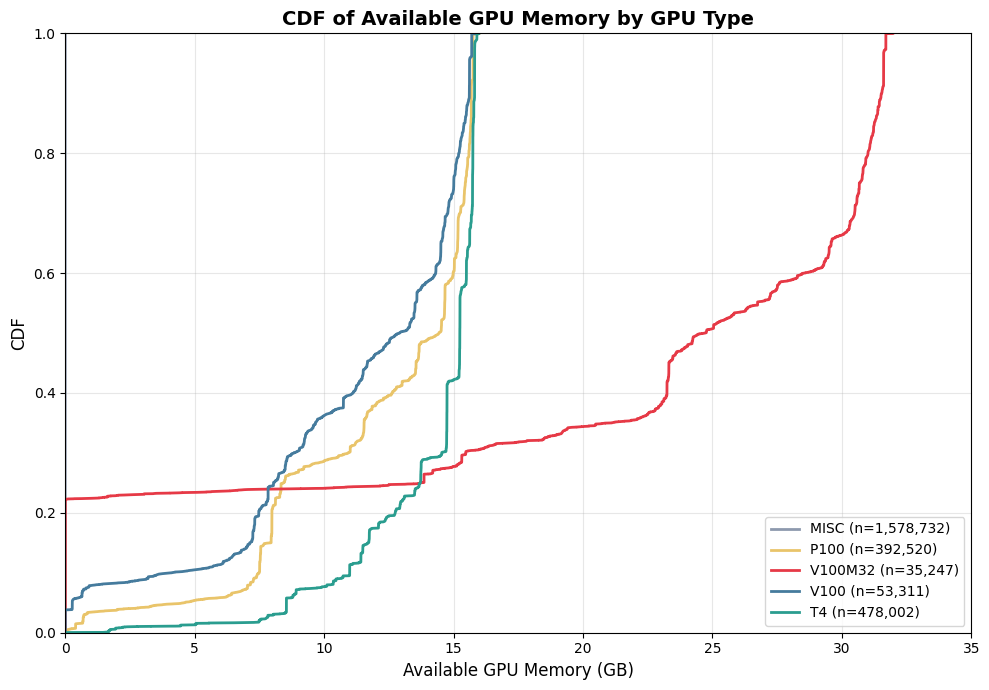

Figure saved as 'gpu_memory_cdf_by_type.png'


In [21]:
# Plot 2: CDF of available GPU memory by GPU type
fig2, ax2 = plt.subplots(figsize=(10, 7))

colors = {'V100M32': '#E63946', 'T4': '#2A9D8F', 'P100': '#E9C46A', 'V100': '#457B9D', 'MISC': '#8D99AE'}

for gpu_type in gpu_data['gpu_type'].unique():
    subset = gpu_data[gpu_data['gpu_type'] == gpu_type]['available_gpu_mem_gb']
    if len(subset) > 10:  # Only plot if enough data points
        sorted_vals = np.sort(subset)
        cdf_vals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        color = colors.get(gpu_type, '#666666')
        ax2.plot(sorted_vals, cdf_vals, linewidth=2, label=f'{gpu_type} (n={len(subset):,})', color=color)

ax2.set_xlabel('Available GPU Memory (GB)', fontsize=12)
ax2.set_ylabel('CDF', fontsize=12)
ax2.set_title('CDF of Available GPU Memory by GPU Type', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 35)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('gpu_memory_cdf_by_type.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'gpu_memory_cdf_by_type.png'")


In [16]:
# Summary table: Available GPU memory percentiles by GPU type
summary_stats = []
for gpu_type in gpu_data['gpu_type'].unique():
    subset = gpu_data[gpu_data['gpu_type'] == gpu_type]['available_gpu_mem_gb']
    if len(subset) > 0:
        capacity = GPU_MEMORY_GB.get(gpu_type, 0)
        summary_stats.append({
            'GPU Type': gpu_type,
            'Capacity (GB)': capacity,
            'Count': len(subset),
            'Mean Available (GB)': subset.mean(),
            'P50 Available (GB)': subset.quantile(0.50),
            'P75 Available (GB)': subset.quantile(0.75),
            'P90 Available (GB)': subset.quantile(0.90),
            'P95 Available (GB)': subset.quantile(0.95),
            'Mean Utilization %': ((capacity - subset.mean()) / capacity * 100) if capacity > 0 else 0
        })

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.round(2)
print("=== Available GPU Memory by GPU Type ===")
summary_df


=== Available GPU Memory by GPU Type ===


,GPU Type,Capacity (GB),Count,Mean Available (GB),P50 Available (GB),P75 Available (GB),P90 Available (GB),P95 Available (GB),Mean Utilization %
0,MISC,-10000000.0,1578732,0.00,0.00,0.00,0.00,0.00,0.00
1,P100,16.0,392520,12.23,14.44,15.45,15.69,15.75,23.55
2,V100M32,32.0,35247,20.31,24.72,30.68,31.54,31.61,36.52
3,V100,16.0,53311,11.16,12.91,15.01,15.61,15.61,30.27
4,T4,16.0,478002,14.14,15.24,15.74,15.81,15.82,11.64


## Grouped GPU Analysis: Aggregated Available Memory

Simulating what happens when we group GPUs together (as in multi-GPU servers with NVLink/NVSwitch interconnects). We sample N GPUs and sum their available memory to simulate rack-level aggregation.


In [17]:
# Group GPUs and aggregate available memory
# We'll simulate grouping by sampling N GPUs and summing their available memory

# GPU group sizes to analyze (common multi-GPU configurations)
GROUP_SIZES = [1, 2, 4, 6, 8]

# Number of samples to draw for each group size
N_SAMPLES = 10000

# Get the available memory values as an array
available_mem_values = gpu_data['available_gpu_mem_gb'].values

np.random.seed(42)  # For reproducibility

grouped_results = {}
for group_size in GROUP_SIZES:
    # Sample groups of GPUs and sum their available memory
    samples = []
    for _ in range(N_SAMPLES):
        # Randomly sample 'group_size' GPUs (with replacement to simulate different jobs)
        group_indices = np.random.choice(len(available_mem_values), size=group_size, replace=True)
        total_available = available_mem_values[group_indices].sum()
        samples.append(total_available)
    
    grouped_results[group_size] = np.array(samples)
    
    print(f"Group size {group_size}: Mean = {np.mean(samples):.2f} GB, "
          f"Median = {np.median(samples):.2f} GB, "
          f"P90 = {np.percentile(samples, 90):.2f} GB")


Group size 1: Mean = 5.17 GB, Median = 0.00 GB, P90 = 15.62 GB
Group size 2: Mean = 10.11 GB, Median = 11.30 GB, P90 = 26.11 GB
Group size 4: Mean = 20.40 GB, Median = 15.80 GB, P90 = 40.14 GB
Group size 6: Mean = 30.45 GB, Median = 30.03 GB, P90 = 54.06 GB
Group size 8: Mean = 40.47 GB, Median = 39.90 GB, P90 = 67.62 GB


In [19]:
# Summary table for grouped GPU configurations
grouped_summary = []
for group_size in GROUP_SIZES:
    data = grouped_results[group_size]
    grouped_summary.append({
        'GPU Group Size': group_size,
        'Mean Available (GB)': np.mean(data),
        'Median (P50) (GB)': np.median(data),
        'P75 (GB)': np.percentile(data, 75),
        'P90 (GB)': np.percentile(data, 90),
        'P95 (GB)': np.percentile(data, 95),
        'P99 (GB)': np.percentile(data, 99),
        'Max (GB)': np.max(data),
    })

grouped_summary_df = pd.DataFrame(grouped_summary)
grouped_summary_df = grouped_summary_df.round(2)
print("=== Aggregated Available GPU Memory by Group Size ===")
print("(Based on random sampling of N GPUs from the workload distribution)")
grouped_summary_df


=== Aggregated Available GPU Memory by Group Size ===
(Based on random sampling of N GPUs from the workload distribution)


,GPU Group Size,Mean Available (GB),Median (P50) (GB),P75 (GB),P90 (GB),P95 (GB),P99 (GB),Max (GB)
0,1,5.17,0.00,13.65,15.62,15.75,18.71,31.70
1,2,10.11,11.30,15.67,26.11,30.41,31.55,47.41
2,4,20.40,15.80,30.36,40.14,45.72,58.27,78.28
3,6,30.45,30.03,42.48,54.06,60.77,73.26,111.33
4,8,40.47,39.90,54.40,67.62,75.27,91.20,120.09
